In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

2023-10-17 03:00:03.368034: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-17 03:00:04.677827: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import tempfile

In [3]:
import tensorflow_model_optimization as tfmot
from tensorflow_model_optimization.sparsity import keras as sparsity

In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


2023-10-17 03:00:08.068365: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-17 03:00:08.094829: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-17 03:00:08.095039: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

### 1. Initialising Dataset

In [5]:
DATASET_ROOT_DIR = "/media/abhishek/data/college/q11/data_science/Incidents-subset-20230213T155459Z-001/incidents-subset_2"
BATCH_SIZE = 32
IMG_SIZE = (160,160)

train_dir = os.path.join(DATASET_ROOT_DIR, 'trainset')
val_dir = os.path.join(DATASET_ROOT_DIR, 'valset')
test_dir = os.path.join(DATASET_ROOT_DIR, 'testset')

trainset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                        shuffle=True,
                                                        batch_size=BATCH_SIZE,
                                                        image_size=IMG_SIZE)

valset = tf.keras.utils.image_dataset_from_directory(val_dir,
                                                        shuffle=True,
                                                        batch_size=BATCH_SIZE,
                                                        image_size=IMG_SIZE)
testset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                        shuffle=True,
                                                        batch_size=BATCH_SIZE,
                                                        image_size=IMG_SIZE)

Found 4704 files belonging to 12 classes.
Found 1176 files belonging to 12 classes.


2023-10-17 03:00:08.441550: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-17 03:00:08.441891: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-17 03:00:08.442026: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Found 4704 files belonging to 12 classes.


In [6]:
for i, b in trainset.take(4):
    print(i.shape)
    print(b.shape)

(32, 160, 160, 3)
(32,)
(32, 160, 160, 3)
(32,)
(32, 160, 160, 3)
(32,)
(32, 160, 160, 3)
(32,)


['airplane accident', 'bicycle accident', 'car accident', 'collapsed', 'earthquake', 'flooded', 'ice storm', 'nuclear explosion', 'oil spill', 'tornado', 'volcanic eruption', 'wildfire']


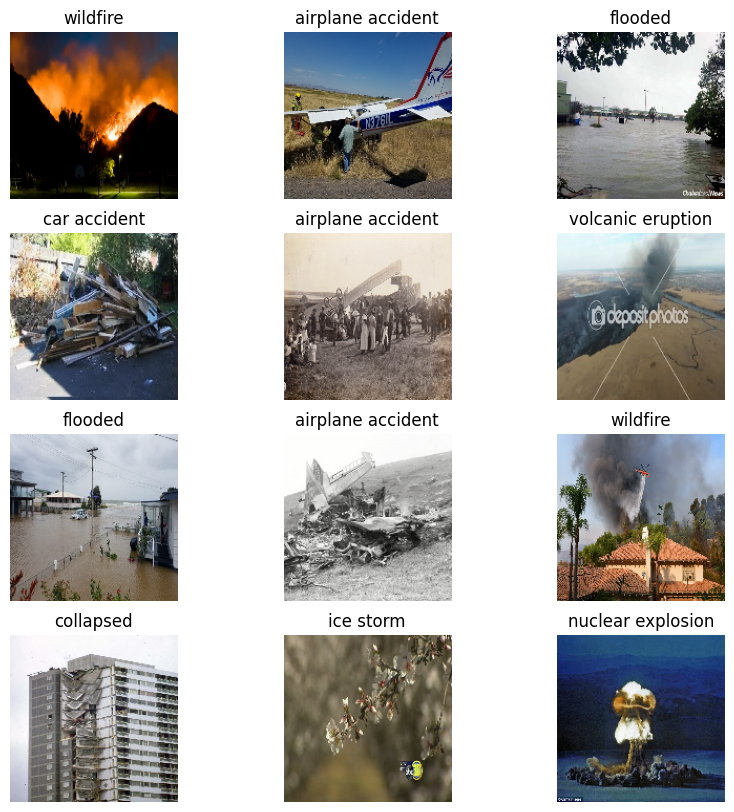

In [7]:
class_names = trainset.class_names
num_classes = len(class_names)
print(class_names)

plt.figure(figsize=(10, 10))
for images, labels in trainset.take(1):
  for i in range(12):
    ax = plt.subplot(4, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [8]:
AUTOTUNE = tf.data.AUTOTUNE

trainset = trainset.prefetch(buffer_size=AUTOTUNE)
trainset = trainset.ignore_errors(log_warning=True)
valset = valset.prefetch(buffer_size=AUTOTUNE)
testset = testset.prefetch(buffer_size=AUTOTUNE)

#### 1.1 Scale Image size to be appropriate for the model

### 2. Create base model from pretrained convnet

In [9]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [10]:
image_batch, label_batch = next(iter(trainset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

2023-10-17 03:00:18.477417: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600


(32, 5, 5, 1280)


In [11]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

#### 2.1 Feature extraction
Freeze the conv layers

Add classification head


In [12]:
base_model.trainable = False

In [13]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [14]:
prediction_layer_1 = tf.keras.layers.Dense(128)
prediction_layer_2 = tf.keras.layers.Dense(num_classes)
prediction_batch = prediction_layer_2(prediction_layer_1(feature_batch_average))
print(prediction_batch.shape)

(32, 12)


In [15]:
inputs = tf.keras.Input(shape=(160, 160, 3))
# x = data_augmentation(inputs)
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = prediction_layer_2(prediction_layer_1(x))
outputs = tf.keras.activations.softmax(x)
model = tf.keras.Model(inputs, outputs)

In [16]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 160, 160, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 160, 160, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                     

In [17]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 80, 80, 32)           0         ['bn_Conv1[

In [20]:
# code from https://www.tensorflow.org/tutorials/images/classification

base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

### 3. Train the model

In [21]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(valset)

37/37 [==============================] - 5s 88ms/step - loss: 3.2499 - accuracy: 0.1020


In [22]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 3.25
initial accuracy: 0.10


In [23]:
history = model.fit(trainset,
                    epochs=initial_epochs,
                    validation_data=valset)

Epoch 1/10


2023-10-17 03:01:18.264010: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x9619240 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-17 03:01:18.264050: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Quadro T1000 with Max-Q Design, Compute Capability 7.5
2023-10-17 03:01:18.293318: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-17 03:01:18.471000: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


     10/Unknown - 4s 104ms/step - loss: 2.9372 - accuracy: 0.1531

2023-10-17 03:01:19.707197: W tensorflow/core/kernels/data/experimental/ignore_errors_dataset_op.cc:119] Error raised with error message Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]


     30/Unknown - 6s 104ms/step - loss: 2.6487 - accuracy: 0.2156

2023-10-17 03:01:21.609588: W tensorflow/core/kernels/data/experimental/ignore_errors_dataset_op.cc:119] Error raised with error message Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]


     58/Unknown - 9s 104ms/step - loss: 2.3091 - accuracy: 0.2974

2023-10-17 03:01:24.780444: W tensorflow/core/kernels/data/experimental/ignore_errors_dataset_op.cc:119] Error raised with error message Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]


     82/Unknown - 12s 110ms/step - loss: 2.1578 - accuracy: 0.3403

2023-10-17 03:01:27.520435: W tensorflow/core/kernels/data/experimental/ignore_errors_dataset_op.cc:119] Error raised with error message Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]


145/145 [==============================] - 26s 156ms/step - loss: 1.8145 - accuracy: 0.4385 - val_loss: 1.0419 - val_accuracy: 0.6565
Epoch 2/10
 11/145 [=>............................] - ETA: 14s - loss: 1.0623 - accuracy: 0.6619

2023-10-17 03:01:43.032917: W tensorflow/core/kernels/data/experimental/ignore_errors_dataset_op.cc:119] Error raised with error message Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]


 30/145 [=====>........................] - ETA: 11s - loss: 1.0353 - accuracy: 0.6667

2023-10-17 03:01:44.795819: W tensorflow/core/kernels/data/experimental/ignore_errors_dataset_op.cc:119] Error raised with error message Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]


 59/145 [===========>..................] - ETA: 8s - loss: 1.0315 - accuracy: 0.6626

2023-10-17 03:01:47.977025: W tensorflow/core/kernels/data/experimental/ignore_errors_dataset_op.cc:119] Error raised with error message Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]


 82/145 [===============>..............] - ETA: 6s - loss: 1.0383 - accuracy: 0.6601

2023-10-17 03:01:50.807802: W tensorflow/core/kernels/data/experimental/ignore_errors_dataset_op.cc:119] Error raised with error message Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]


145/145 [==============================] - 21s 139ms/step - loss: 1.0023 - accuracy: 0.6737 - val_loss: 0.8183 - val_accuracy: 0.7279
Epoch 3/10
 11/145 [=>............................] - ETA: 16s - loss: 0.7024 - accuracy: 0.7585

2023-10-17 03:02:04.035683: W tensorflow/core/kernels/data/experimental/ignore_errors_dataset_op.cc:119] Error raised with error message Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]


 30/145 [=====>........................] - ETA: 11s - loss: 0.7692 - accuracy: 0.7333

2023-10-17 03:02:05.791485: W tensorflow/core/kernels/data/experimental/ignore_errors_dataset_op.cc:119] Error raised with error message Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]


 58/145 [===========>..................] - ETA: 8s - loss: 0.8167 - accuracy: 0.7220

2023-10-17 03:02:08.828443: W tensorflow/core/kernels/data/experimental/ignore_errors_dataset_op.cc:119] Error raised with error message Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]


 82/145 [===============>..............] - ETA: 6s - loss: 0.8249 - accuracy: 0.7264

2023-10-17 03:02:11.388920: W tensorflow/core/kernels/data/experimental/ignore_errors_dataset_op.cc:119] Error raised with error message Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]


145/145 [==============================] - 19s 127ms/step - loss: 0.8105 - accuracy: 0.7342 - val_loss: 0.7096 - val_accuracy: 0.7619
Epoch 4/10
 11/145 [=>............................] - ETA: 15s - loss: 0.6578 - accuracy: 0.7841

2023-10-17 03:02:23.031289: W tensorflow/core/kernels/data/experimental/ignore_errors_dataset_op.cc:119] Error raised with error message Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]


 30/145 [=====>........................] - ETA: 11s - loss: 0.6344 - accuracy: 0.7885

2023-10-17 03:02:24.741991: W tensorflow/core/kernels/data/experimental/ignore_errors_dataset_op.cc:119] Error raised with error message Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]


 59/145 [===========>..................] - ETA: 8s - loss: 0.6676 - accuracy: 0.7791

2023-10-17 03:02:27.732830: W tensorflow/core/kernels/data/experimental/ignore_errors_dataset_op.cc:119] Error raised with error message Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]


 82/145 [===============>..............] - ETA: 6s - loss: 0.6976 - accuracy: 0.7710

2023-10-17 03:02:30.307060: W tensorflow/core/kernels/data/experimental/ignore_errors_dataset_op.cc:119] Error raised with error message Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]


145/145 [==============================] - 19s 128ms/step - loss: 0.7055 - accuracy: 0.7697 - val_loss: 0.6655 - val_accuracy: 0.7764
Epoch 5/10
 11/145 [=>............................] - ETA: 17s - loss: 0.5180 - accuracy: 0.8011

2023-10-17 03:02:42.411094: W tensorflow/core/kernels/data/experimental/ignore_errors_dataset_op.cc:119] Error raised with error message Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]


 30/145 [=====>........................] - ETA: 11s - loss: 0.5549 - accuracy: 0.8083

2023-10-17 03:02:44.197842: W tensorflow/core/kernels/data/experimental/ignore_errors_dataset_op.cc:119] Error raised with error message Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]


 59/145 [===========>..................] - ETA: 8s - loss: 0.5978 - accuracy: 0.8040

2023-10-17 03:02:47.199228: W tensorflow/core/kernels/data/experimental/ignore_errors_dataset_op.cc:119] Error raised with error message Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]


 82/145 [===============>..............] - ETA: 6s - loss: 0.6361 - accuracy: 0.7889

2023-10-17 03:02:49.782575: W tensorflow/core/kernels/data/experimental/ignore_errors_dataset_op.cc:119] Error raised with error message Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]


145/145 [==============================] - 19s 127ms/step - loss: 0.6314 - accuracy: 0.7933 - val_loss: 0.6394 - val_accuracy: 0.7840
Epoch 6/10
 11/145 [=>............................] - ETA: 15s - loss: 0.5110 - accuracy: 0.8381

2023-10-17 03:03:01.507431: W tensorflow/core/kernels/data/experimental/ignore_errors_dataset_op.cc:119] Error raised with error message Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]


 30/145 [=====>........................] - ETA: 11s - loss: 0.5281 - accuracy: 0.8292

2023-10-17 03:03:03.240466: W tensorflow/core/kernels/data/experimental/ignore_errors_dataset_op.cc:119] Error raised with error message Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]


 58/145 [===========>..................] - ETA: 8s - loss: 0.5674 - accuracy: 0.8130

2023-10-17 03:03:06.165441: W tensorflow/core/kernels/data/experimental/ignore_errors_dataset_op.cc:119] Error raised with error message Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]


 82/145 [===============>..............] - ETA: 6s - loss: 0.5838 - accuracy: 0.8049

2023-10-17 03:03:08.735981: W tensorflow/core/kernels/data/experimental/ignore_errors_dataset_op.cc:119] Error raised with error message Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]


145/145 [==============================] - 19s 127ms/step - loss: 0.5874 - accuracy: 0.8087 - val_loss: 0.6125 - val_accuracy: 0.7891
Epoch 7/10
 11/145 [=>............................] - ETA: 15s - loss: 0.4448 - accuracy: 0.8466

2023-10-17 03:03:20.635879: W tensorflow/core/kernels/data/experimental/ignore_errors_dataset_op.cc:119] Error raised with error message Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]


 30/145 [=====>........................] - ETA: 11s - loss: 0.4879 - accuracy: 0.8365

2023-10-17 03:03:22.407611: W tensorflow/core/kernels/data/experimental/ignore_errors_dataset_op.cc:119] Error raised with error message Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]


 58/145 [===========>..................] - ETA: 8s - loss: 0.5251 - accuracy: 0.8270

2023-10-17 03:03:25.321447: W tensorflow/core/kernels/data/experimental/ignore_errors_dataset_op.cc:119] Error raised with error message Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]


 82/145 [===============>..............] - ETA: 6s - loss: 0.5331 - accuracy: 0.8243

2023-10-17 03:03:27.904133: W tensorflow/core/kernels/data/experimental/ignore_errors_dataset_op.cc:119] Error raised with error message Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]


145/145 [==============================] - 19s 126ms/step - loss: 0.5431 - accuracy: 0.8247 - val_loss: 0.5980 - val_accuracy: 0.7968
Epoch 8/10
 11/145 [=>............................] - ETA: 15s - loss: 0.4022 - accuracy: 0.8580

2023-10-17 03:03:39.618710: W tensorflow/core/kernels/data/experimental/ignore_errors_dataset_op.cc:119] Error raised with error message Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]


 30/145 [=====>........................] - ETA: 11s - loss: 0.4780 - accuracy: 0.8417

2023-10-17 03:03:41.320841: W tensorflow/core/kernels/data/experimental/ignore_errors_dataset_op.cc:119] Error raised with error message Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]


 59/145 [===========>..................] - ETA: 8s - loss: 0.4810 - accuracy: 0.8422

2023-10-17 03:03:44.236054: W tensorflow/core/kernels/data/experimental/ignore_errors_dataset_op.cc:119] Error raised with error message Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]


 82/145 [===============>..............] - ETA: 6s - loss: 0.4961 - accuracy: 0.8338

2023-10-17 03:03:46.793138: W tensorflow/core/kernels/data/experimental/ignore_errors_dataset_op.cc:119] Error raised with error message Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]


145/145 [==============================] - 19s 126ms/step - loss: 0.5039 - accuracy: 0.8338 - val_loss: 0.5869 - val_accuracy: 0.8002
Epoch 9/10
 11/145 [=>............................] - ETA: 15s - loss: 0.4274 - accuracy: 0.8580

2023-10-17 03:03:58.647095: W tensorflow/core/kernels/data/experimental/ignore_errors_dataset_op.cc:119] Error raised with error message Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]


 30/145 [=====>........................] - ETA: 11s - loss: 0.4552 - accuracy: 0.8479

2023-10-17 03:04:00.382069: W tensorflow/core/kernels/data/experimental/ignore_errors_dataset_op.cc:119] Error raised with error message Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]


 59/145 [===========>..................] - ETA: 8s - loss: 0.4683 - accuracy: 0.8448

2023-10-17 03:04:03.321866: W tensorflow/core/kernels/data/experimental/ignore_errors_dataset_op.cc:119] Error raised with error message Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]


 82/145 [===============>..............] - ETA: 6s - loss: 0.4940 - accuracy: 0.8365

2023-10-17 03:04:05.901665: W tensorflow/core/kernels/data/experimental/ignore_errors_dataset_op.cc:119] Error raised with error message Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]


145/145 [==============================] - 19s 127ms/step - loss: 0.4832 - accuracy: 0.8423 - val_loss: 0.5804 - val_accuracy: 0.7976
Epoch 10/10
 11/145 [=>............................] - ETA: 15s - loss: 0.3734 - accuracy: 0.8807

2023-10-17 03:04:17.735904: W tensorflow/core/kernels/data/experimental/ignore_errors_dataset_op.cc:119] Error raised with error message Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]


 30/145 [=====>........................] - ETA: 11s - loss: 0.4142 - accuracy: 0.8594

2023-10-17 03:04:19.520575: W tensorflow/core/kernels/data/experimental/ignore_errors_dataset_op.cc:119] Error raised with error message Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]


 58/145 [===========>..................] - ETA: 8s - loss: 0.4393 - accuracy: 0.8529

2023-10-17 03:04:22.531218: W tensorflow/core/kernels/data/experimental/ignore_errors_dataset_op.cc:119] Error raised with error message Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]


 82/145 [===============>..............] - ETA: 6s - loss: 0.4563 - accuracy: 0.8449

2023-10-17 03:04:25.074154: W tensorflow/core/kernels/data/experimental/ignore_errors_dataset_op.cc:119] Error raised with error message Unknown image file format. One of JPEG, PNG, GIF, BMP required.
	 [[{{node decode_image/DecodeImage}}]]


145/145 [==============================] - 19s 129ms/step - loss: 0.4691 - accuracy: 0.8442 - val_loss: 0.5797 - val_accuracy: 0.8070


In [24]:
model(trainset.take(1).get_single_element(0)[0])

<tf.Tensor: shape=(32, 12), dtype=float32, numpy=
array([[5.62329296e-06, 1.09110551e-05, 6.48259402e-06, 7.32743138e-06,
        1.35406572e-05, 1.36186782e-06, 2.97204906e-06, 3.06786824e-05,
        2.47666991e-04, 4.87261968e-06, 9.96351600e-01, 3.31698544e-03],
       [5.23021929e-02, 4.40760014e-05, 2.70634337e-04, 7.92904422e-02,
        6.96344243e-04, 4.08335385e-04, 2.77738611e-04, 9.70534806e-04,
        8.00284818e-02, 7.15744257e-01, 6.98506609e-02, 1.16296687e-04],
       [1.73857465e-04, 1.34967873e-03, 4.29018214e-03, 1.71352737e-03,
        1.20963059e-05, 3.36493358e-05, 6.81979600e-06, 5.96835685e-04,
        2.25185021e-03, 2.17776615e-04, 2.78589949e-02, 9.61494744e-01],
       [1.28929121e-02, 2.70188903e-03, 9.24857915e-04, 5.63510716e-01,
        4.09450561e-01, 2.54296791e-03, 3.65599222e-03, 1.58932235e-04,
        3.24597023e-03, 1.69055293e-05, 4.34090238e-04, 4.64171841e-04],
       [3.24913039e-04, 8.30516947e-05, 3.66173859e-04, 8.70961487e-01,
        1.

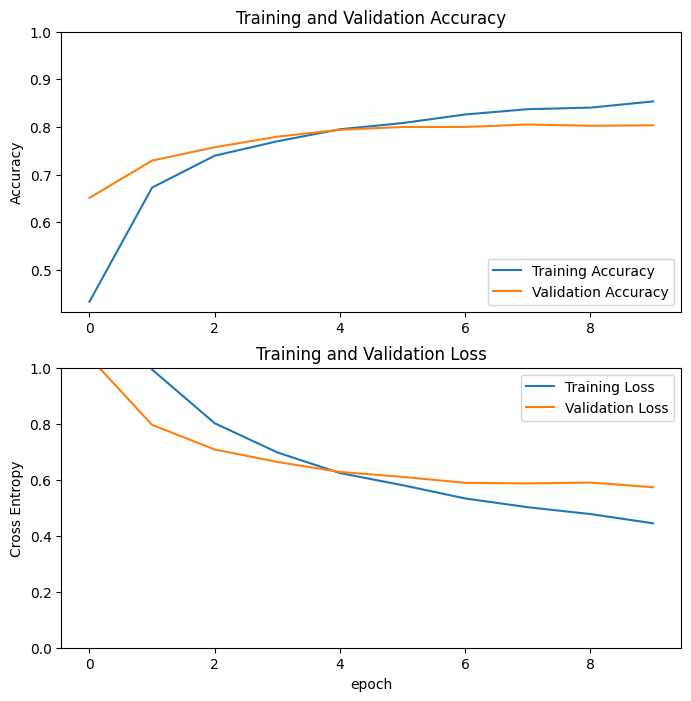

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [22]:

model.save_weights("mobile_net_trained_incidents_1.h5", overwrite=True)

In [33]:
base_model_trained = model.layers[3]
base_model_trained = sparsity.prune_low_magnitude(base_model_trained)
base_model_trained.save_weights("mobile_net_trained_incidents_1.h5", overwrite=True)

In [ ]:
base_model_trained.summary()

In [23]:
#Understanding base model

conv_layers_full_size = {}

for layer in base_model.layers:
    
    if isinstance(layer, tf.keras.layers.Conv2D):
        # print(layer.name, end="\t")
        # print(layer.count_params())
        conv_layers_full_size[layer.name] = layer.count_params()
        # print(tf.math.count_nonzero(layer.trainable_weights, axis=None))

print()
print(conv_layers_full_size)
print(sum(conv_layers_full_size.values()))


{'Conv1': 864, 'expanded_conv_project': 512, 'block_1_expand': 1536, 'block_1_project': 2304, 'block_2_expand': 3456, 'block_2_project': 3456, 'block_3_expand': 3456, 'block_3_project': 4608, 'block_4_expand': 6144, 'block_4_project': 6144, 'block_5_expand': 6144, 'block_5_project': 6144, 'block_6_expand': 6144, 'block_6_project': 12288, 'block_7_expand': 24576, 'block_7_project': 24576, 'block_8_expand': 24576, 'block_8_project': 24576, 'block_9_expand': 24576, 'block_9_project': 24576, 'block_10_expand': 24576, 'block_10_project': 36864, 'block_11_expand': 55296, 'block_11_project': 55296, 'block_12_expand': 55296, 'block_12_project': 55296, 'block_13_expand': 55296, 'block_13_project': 92160, 'block_14_expand': 153600, 'block_14_project': 153600, 'block_15_expand': 153600, 'block_15_project': 153600, 'block_16_expand': 153600, 'block_16_project': 307200, 'Conv_1': 409600}
2125536


In [24]:
pruning_params_unpruned = {
    'pruning_schedule': sparsity.ConstantSparsity(
        target_sparsity=0.0, begin_step=0,
         frequency=100
    )
}

pruning_params_t2 = {
    'pruning_schedule': sparsity.ConstantSparsity(
        target_sparsity=0.81, begin_step=0,
         frequency=100
    )
}

In [32]:
conv_layers_pruned_size = {}


def clone_layers_mobilenet(layer_i):
    if isinstance(layer_i, tf.keras.layers.Conv2D):
        ret_layer = sparsity.prune_low_magnitude(layer_i, pruning_params_t2, name = layer_i.name)
        print(layer_i.name, "\t", ret_layer.name)
        # ret_layer.name = layer_i.name
        return ret_layer
    else:
        return layer_i


pruned_mobilenet = tf.keras.models.clone_model(base_model_trained, clone_function=clone_layers_mobilenet)
pruned_mobilenet.load_weights("mobile_net_trained_incidents_1.h5")
sparsity.strip_pruning(pruned_mobilenet)

# pruned_mobilenet.summary(expand_nested=True)

for layer in pruned_mobilenet.layers:
    print(type(layer))
    # try:
    #     print(tf.math.count_nonzero(layer.trainable_weights))
    # except:
    #     print("bl\n")
    
    if isinstance(layer, tf.keras.layers.Conv2D):
        print(layer.name, end="\t")
        print(layer.count_params())
        # conv_layers_pruned_size[layer.name] = layer.count_params()
        print(tf.math.count_nonzero(layer.trainable_weights, axis=None))
        
        
        # print(tf.math.count_nonzero(layer.trainable_weights, axis=None))

print()
print(conv_layers_pruned_size)
print(sum(conv_layers_pruned_size.values()))

Conv1 	 prune_low_magnitude_Conv1
expanded_conv_project 	 prune_low_magnitude_expanded_conv_project
block_1_expand 	 prune_low_magnitude_block_1_expand
block_1_project 	 prune_low_magnitude_block_1_project
block_2_expand 	 prune_low_magnitude_block_2_expand
block_2_project 	 prune_low_magnitude_block_2_project
block_3_expand 	 prune_low_magnitude_block_3_expand
block_3_project 	 prune_low_magnitude_block_3_project
block_4_expand 	 prune_low_magnitude_block_4_expand
block_4_project 	 prune_low_magnitude_block_4_project
block_5_expand 	 prune_low_magnitude_block_5_expand
block_5_project 	 prune_low_magnitude_block_5_project
block_6_expand 	 prune_low_magnitude_block_6_expand
block_6_project 	 prune_low_magnitude_block_6_project
block_7_expand 	 prune_low_magnitude_block_7_expand
block_7_project 	 prune_low_magnitude_block_7_project
block_8_expand 	 prune_low_magnitude_block_8_expand
block_8_project 	 prune_low_magnitude_block_8_project
block_9_expand 	 prune_low_magnitude_block_9_expand


ValueError: Weight count mismatch for layer #0 (named prune_low_magnitude_Conv1 in the current model, Conv1 in the save file). Layer expects 4 weight(s). Received 1 saved weight(s)

In [54]:
pruning_curve = []
limit = 0.09
step_i_size = 1
while step_i_size > limit:
    pruning_curve.append(step_i_size)
    step_i_size *= 0.9
pruning_curve = np.asarray(pruning_curve)
np.round(pruning_curve, 3)
print("Percentage of non-zero weights in pruning steps:", pruning_curve)
print("number of pruning steps: ", pruning_curve.shape)

Percentage of non-zero weights in pruning steps: [1.         0.9        0.81       0.729      0.6561     0.59049
 0.531441   0.4782969  0.43046721 0.38742049 0.34867844 0.3138106
 0.28242954 0.25418658 0.22876792 0.20589113 0.18530202 0.16677182
 0.15009464 0.13508517 0.12157665 0.10941899 0.09847709]
number of pruning steps:  (23,)


In [48]:
conv_layers_pruning_steps = {}

i = 0
for k,v in conv_layers_full_size.items():
    
    i+=1
    if i > 17:
        print(list(conv_layers_full_size.keys())[i])
        original_size = v
        step_k_size = original_size
        while step_k_size > original_size / 1       

block_9_expand
block_9_project
block_10_expand
block_10_project
block_11_expand
block_11_project
block_12_expand
block_12_project
block_13_expand
block_13_project
block_14_expand
block_14_project
block_15_expand
block_15_project
block_16_expand
block_16_project
Conv_1


IndexError: list index out of range

In [53]:
pruning_curve = []
limit = 0.09
step_i_size = 1
while step_i_size > limit:
    pruning_curve.append(step_i_size)
    step_i_size *= 0.9
pruning_curve = np.asarray(pruning_curve)
np.round(pruning_curve, 3)
pruning_curve.shape

(23,)

In [44]:
len(conv_layers_full_size)

35

### 4. Fine tuning
Unfreeze the top layers

In [28]:
base_model.trainable = True


In [24]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154
